# Import Libraries

In [2]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [3]:
from choices import param_dict 
from utilities import deets

# Load data

In [21]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',])


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

### Using Sklearn API

In [5]:
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.1)
    cl_weight[cl] = w
cl_weight

{'STAR': 1.3179470606104418,
 'AGN': 1.3793432990559484,
 'YSO': 1.9552370229762268,
 'HMXB': 2.8022839541992157,
 'ULX': 38.32697077567007,
 'CV': 102.83057251027365,
 'LMXB': 222.57478508947435,
 'PULSAR': 2013.0523019776572}

In [6]:

train_data = lgb.Dataset(x_train , label=y_train)
test_data = lgb.Dataset(x_test , label=y_test , reference=train_data )
clf = lgb.LGBMClassifier(n_estimators=10 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity=0 , validation_fraction=0.2 ,random_state=42 , num_class = 2)
clf.fit(x_train , y_train ,)
#clf.score(x_test , y_test)

[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: validation_fraction
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.


LGBMClassifier(class_weight={'AGN': 1.3793432990559484,
                             'CV': 102.83057251027365,
                             'HMXB': 2.8022839541992157,
                             'LMXB': 222.57478508947435,
                             'PULSAR': 2013.0523019776572,
                             'STAR': 1.3179470606104418,
                             'ULX': 38.32697077567007,
                             'YSO': 1.9552370229762268},
               is_unbalance=True, metric=['auc_mu'], n_estimators=10,
               num_class=2, objective='multiclass', random_state=42,
               sparse=True, validation_fraction=0.2, verbosity=0)

In [7]:
x_test.iloc[0:2]

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J203423.6+405851,5.018995,2.224580,9.650197,0.001888,5.035169,7.5,6.42087,1.0,4.026663e-08,0.002495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.126973,NaN,NaN
2CXO J053505.4-052717,3.908927,5.806955,10.000000,0.008150,10.000000,10.0,10.00000,8.0,9.106110e-10,0.002800,...,5.319602,3.416715,4.484082,NaN,3.870819,NaN,4.116914,3.933575,NaN,NaN


In [8]:
clf.predict(x_test)

array(['YSO', 'STAR', 'AGN', ..., 'AGN', 'STAR', 'YSO'], dtype=object)

In [9]:
pre

NameError: name 'pre' is not defined

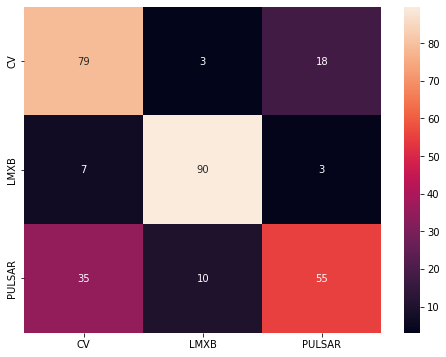

In [ ]:
from sklearn.metrics import confusion_matrix
label = np.unique(y_test)
bst_clf = clf.best_iteration_
cm = confusion_matrix(y_test , clf.predict(x_test) , labels = label , normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm*100 , fmt='.0f' , annot=True , xticklabels=label, yticklabels=label)
plt.show()

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier


## Cross validation

In [14]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
w_i = [np.power(el , 2) for el in cl_dict.values()]
w = [sum(w_i)/el for el in w_i]
for cl , val in zip(cl_dict.keys() , w):
    cl_weight[cl] = val
cl_weight


{'STAR': 1.9914095720764122,
 'AGN': 2.702451828574666,
 'YSO': 11.746756006966933,
 'HMXB': 27.742564400845627,
 'ULX': 347.3566051608837,
 'CV': 560.8486630109107,
 'LMXB': 763.3773468759618,
 'PULSAR': 1512.094497789971}

In [15]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res_arr = []
from tqdm import tqdm
#for i in tqdm(range(5)):
res = simple_cv(x,y ,model=clf , k=10 , normalize_prob=0)
#res_arr.append(res)

----------------------------------------------------------
GOING for 1 / 10 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 2 / 10 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 3 / 10 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 4 / 10 Iteration FOLD
___________________________________________________________
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
----------------------------------------------------------
GOING for 5 / 10 

In [11]:
res['res_table']

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J125955.6+124153,AGN,AGN,0.969550,9.695502e-01,5.915685e-04,2.327238e-05,7.947827e-06,1.937515e-03,8.992630e-05,2.779466e-02,4.864532e-06
2CXO J053608.2-064836,STAR,STAR,0.999972,5.434037e-06,1.668510e-06,1.759385e-05,5.472126e-07,7.416645e-07,9.999724e-01,2.525344e-07,1.381966e-06
2CXO J100513.3-074315,LMXB,LMXB,0.999999,8.677223e-08,9.892054e-08,6.870271e-08,9.999989e-01,7.355048e-07,5.989718e-08,2.641899e-08,3.009478e-09
2CXO J113509.9-605500,STAR,STAR,0.999989,2.725897e-07,1.573270e-07,3.607809e-07,7.944745e-08,2.097760e-07,9.999894e-01,3.275630e-08,9.451063e-06
2CXO J100512.0-074356,LMXB,LMXB,0.999999,7.406643e-08,3.951808e-08,2.346373e-07,9.999992e-01,1.949733e-07,2.136803e-07,2.298038e-08,2.414290e-09
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J110940.1-762839,STAR,STAR,0.999995,1.091373e-06,2.037166e-06,3.937535e-07,1.117474e-07,9.875300e-07,9.999951e-01,1.708873e-07,8.532735e-08
2CXO J115237.3-022807,ULX,AGN,0.513605,5.136046e-01,2.352734e-03,5.875426e-05,9.981892e-06,3.831432e-05,1.468063e-04,4.837802e-01,8.551464e-06
2CXO J150910.5-584907,STAR,STAR,0.999990,5.349374e-08,5.057546e-06,4.559974e-07,7.019721e-08,7.438631e-07,9.999898e-01,1.676378e-08,3.772751e-06


In [12]:
pd.options.display.float_format = '{:,.2f}'.format
class_scores = res['class_scores']
print(class_scores.to_markdown())

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.970772 |          0.967541 |   0.969154 |
| CV      |       0.566265 |          0.5875   |   0.576687 |
| HMXB    |       0.899733 |          0.919399 |   0.909459 |
| LMXB    |       0.804196 |          0.974576 |   0.881226 |
| PULSAR  |       0.465347 |          0.408696 |   0.435185 |
| STAR    |       0.953047 |          0.954072 |   0.953559 |
| ULX     |       0.677725 |          0.658986 |   0.668224 |
| YSO     |       0.94604  |          0.928266 |   0.937069 |


In [62]:
res

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2713
 AGN           2329
 YSO           1141
 HMXB           711
 ULX            258
 PULSAR         220
 CV             197
 LMXB           134,
 'balanced_accuracy': 0.8036310201690892,
 'accuracy': 0.9104245099311956,
 'precision': 0.9246237387682111,
 'recall': 0.9104245099311956,
 'f1': 0.9162462889688165,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN             0.95             0.97      0.96
 CV              0.58             0.49      0.53
 HMXB            0.85             0.90      0.87
 LMXB            0.83             0.88      0.85
 PULSAR          0.61             0.28      0.39
 STAR            0.94             0.96      0.95
 ULX             0.75             0.62      0.68
 YSO             0.92             0.93      0.92,
 'res_table':                  

Text(0.5, 1.0, 'CF for LighgGBM,')

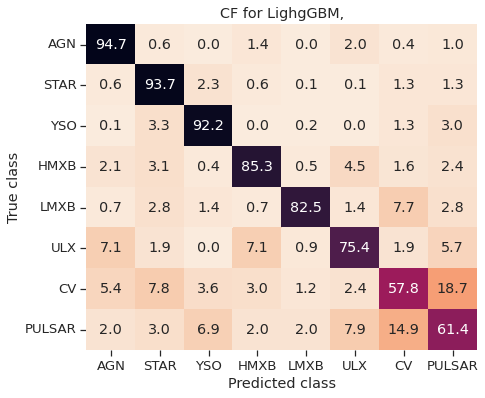

In [63]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 ,
    'cbar' : False ,
    'plot_num' : 0,
}
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(7,6))
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0. , ax=ax)
plt.title('CF for LighgGBM,')
#plt.savefig('temp_res_comp/cf/lightGBM_rf.png')

In [12]:
res['res_table'].to_csv('temp_res_comp/train_prob_dist/lightGBM.csv')

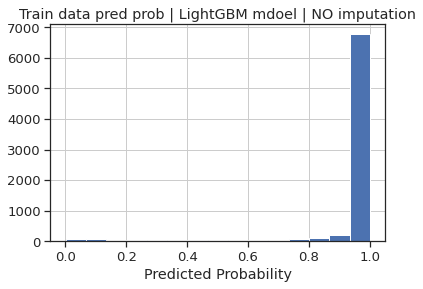

In [64]:
plt.hist(res['res_table']['pred_prob'] , bins=15)
plt.title('Train data pred prob | LightGBM mdoel | NO imputation')
plt.xlabel('Predicted Probability')
#plt.savefig('temp_res_comp/train_prob_dist/LightGBM_prob.jpg')
plt.show()

### Prediction on New sources

In [65]:
from utilities import softmax , norm_prob
clf = res['clf']
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.01,0.78,1.00,0.00,0.77,0.02,0.01,0.00
2CXO J005449.0-725128,0.03,0.19,0.67,0.00,0.06,0.03,0.00,0.00
2CXO J010049.1-731526,0.01,0.41,0.61,0.00,0.69,0.13,0.01,0.00
2CXO J010049.8-731045,0.01,0.17,0.41,0.00,0.51,0.04,0.00,0.00
2CXO J010647.7-730940,0.00,0.76,0.96,0.00,0.55,0.19,0.00,0.00
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.05,0.99,0.00,0.00,0.06,0.03,0.06,0.00
2CXO J220508.3-495935,0.01,0.96,0.01,0.00,0.04,0.01,0.14,0.00
2CXO J220544.0-495505,0.22,0.41,0.02,0.00,0.00,0.03,0.01,0.00
2CXO J220555.6-500837,0.00,0.11,0.47,0.00,0.00,0.00,0.06,0.00


In [66]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,1.00,0.21,0.01,0.78,1.00,0.00,0.77,0.02,0.01,0.00
2CXO J005449.0-725128,HMXB,0.67,0.48,0.03,0.19,0.67,0.00,0.06,0.03,0.00,0.00
2CXO J010049.1-731526,PULSAR,0.69,0.08,0.01,0.41,0.61,0.00,0.69,0.13,0.01,0.00
2CXO J010049.8-731045,PULSAR,0.51,0.10,0.01,0.17,0.41,0.00,0.51,0.04,0.00,0.00
2CXO J010647.7-730940,HMXB,0.96,0.21,0.00,0.76,0.96,0.00,0.55,0.19,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,CV,0.99,0.92,0.05,0.99,0.00,0.00,0.06,0.03,0.06,0.00
2CXO J220508.3-495935,CV,0.96,0.82,0.01,0.96,0.01,0.00,0.04,0.01,0.14,0.00
2CXO J220544.0-495505,CV,0.41,0.19,0.22,0.41,0.02,0.00,0.00,0.03,0.01,0.00


In [67]:
u_df.to_csv('temp_res_comp/unid_prob/lightGBM.csv')

In [68]:
u_df = pd.read_csv('temp_res_comp/unid_prob/lightGBM.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,HMXB,1.00,0.21,0.01,0.78,1.00,0.00,0.77,0.02,0.01,0.00
2CXO J005449.0-725128,HMXB,0.67,0.48,0.03,0.19,0.67,0.00,0.06,0.03,0.00,0.00
2CXO J010049.1-731526,PULSAR,0.69,0.08,0.01,0.41,0.61,0.00,0.69,0.13,0.01,0.00
2CXO J010049.8-731045,PULSAR,0.51,0.10,0.01,0.17,0.41,0.00,0.51,0.04,0.00,0.00
2CXO J010647.7-730940,HMXB,0.96,0.21,0.00,0.76,0.96,0.00,0.55,0.19,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,CV,0.99,0.92,0.05,0.99,0.00,0.00,0.06,0.03,0.06,0.00
2CXO J220508.3-495935,CV,0.96,0.82,0.01,0.96,0.01,0.00,0.04,0.01,0.14,0.00
2CXO J220544.0-495505,CV,0.41,0.19,0.22,0.41,0.02,0.00,0.00,0.03,0.01,0.00


In [69]:
u_df_th = u_df[u_df['prob']>0.9]
print(u_df_th['class'].value_counts().to_markdown())

|        |   class |
|:-------|--------:|
| STAR   |    6137 |
| AGN    |    5039 |
| YSO    |    4757 |
| HMXB   |    2830 |
| PULSAR |    1953 |
| ULX    |    1107 |
| CV     |     824 |
| LMXB   |     155 |


In [70]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
fig.write_image('temp_res_comp/unid_prob_dist/lightGBM.jpg')
fig.show()

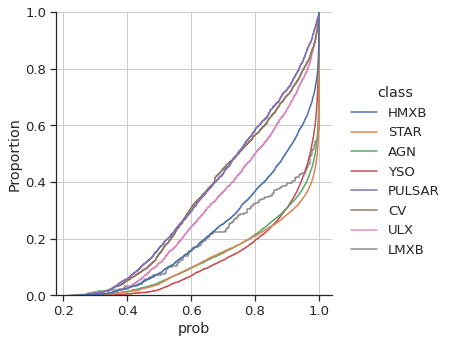

In [39]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()